In [ ]:
import glob
import math
import os
import random
import shutil

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import autograd
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset, random_split, Subset

import torchvision
from torchvision import datasets, transforms

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 4
MANUAL_SEED = 1
HIDDEN_SIZE = 256
INPUT_SIZE = 14

In [3]:
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    print(f"Found {num_devices} CUDA device(s):")
    for i in range(num_devices):
        print(f"CUDA:{i} - {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Using CPU.")

Found 1 CUDA device(s):
CUDA:0 - NVIDIA GeForce RTX 5090


Here, a custom class is used to process the scanpath (.png) images and separate them into their respective classes (literate/illiterate).

In [ ]:
class ScanpathDataset(Dataset):
    def __init__(self, img_root, seq_root, transform=None):
        self.samples = []
        self.transform = transform
        self.label_map = {"literate": 0, "illiterate": 1}

        for label_name, label in self.label_map.items():
            img_dir = os.path.join(img_root, label_name)
            seq_dir = os.path.join(seq_root, label_name)

            for img_path in glob.glob(os.path.join(img_dir, "*.png")):
                base = os.path.splitext(os.path.basename(img_path))[0]
                csv_path = os.path.join(seq_dir, base + ".csv")
                if os.path.exists(csv_path):
                    self.samples.append((img_path, csv_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, seq_path, label = self.samples[idx]

        img = Image.open(img_path).convert("L")
        if self.transform:
            img = self.transform(img)

        df = pd.read_csv(seq_path)

        numeric_df = df.select_dtypes(include=["number"])

        if numeric_df.empty:
            raise ValueError(f"No numeric columns found in {seq_path}!")

        seq = torch.tensor(numeric_df.values, dtype=torch.float32)

        return img, seq, label


In [ ]:
def collate_fn(batch):
    images, seqs, labels = zip(*batch)

    images = torch.stack(images)

    seq_lengths = torch.tensor([len(seq) for seq in seqs])
    padded_seqs = pad_sequence(seqs, batch_first=True)

    labels = torch.tensor(labels, dtype=torch.long)

    return images, padded_seqs, seq_lengths, labels


In [6]:
class VTNet(nn.Module):
    def __init__(self,
                 input_size=50,
                 rnn_hidden_size=256,
                 output_size=2,
                 rnn_type='gru',
                 rnn_num_layers=1,
                 n_channels_1=6,
                 kernel_size_1=5,
                 n_channels_2=16,
                 kernel_size_2=5,
                 img_n_vert=150,
                 img_n_hor=150):
        super(VTNet, self).__init__()

        self.rnn_type = rnn_type
        self.rnn_hidden_size = rnn_hidden_size
        self.rnn_num_layers = rnn_num_layers
        self.n_channels_2 = n_channels_2

        # --- CNN branch ---
        self.conv1 = nn.Conv2d(1, n_channels_1, kernel_size=kernel_size_1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(n_channels_1, n_channels_2, kernel_size=kernel_size_2)

        # calculate CNN output size
        conv1_out_vert = img_n_vert - kernel_size_1 + 1
        conv1_out_hor = img_n_hor - kernel_size_1 + 1
        mp1_out_vert = (conv1_out_vert - 2) // 2 + 1
        mp1_out_hor = (conv1_out_hor - 2) // 2 + 1
        conv2_out_vert = mp1_out_vert - kernel_size_2 + 1
        conv2_out_hor = mp1_out_hor - kernel_size_2 + 1
        mp2_out_vert = (conv2_out_vert - 2) // 2 + 1
        mp2_out_hor = (conv2_out_hor - 2) // 2 + 1

        self.fc1 = nn.Linear(n_channels_2 * mp2_out_hor * mp2_out_vert, 50)
        self.fc2 = nn.Linear(rnn_hidden_size + 50, 20)
        # --- Attention projection layers ---
        # project CNN features -> query, and RNN outputs -> keys/values
        self.attn_query = nn.Linear(50, rnn_hidden_size)
        self.attn_key = nn.Linear(rnn_hidden_size, rnn_hidden_size)
        self.attn_value = nn.Linear(rnn_hidden_size, rnn_hidden_size)
        self.fc3 = nn.Linear(20, output_size)

        # --- RNN branch ---
        if rnn_type == 'gru':
            self.rnn = nn.GRU(input_size=input_size, hidden_size=rnn_hidden_size,
                              num_layers=rnn_num_layers, batch_first=True)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size=input_size, hidden_size=rnn_hidden_size,
                               num_layers=rnn_num_layers, batch_first=True)
        else:
            self.rnn = nn.RNN(input_size=input_size, hidden_size=rnn_hidden_size,
                              num_layers=rnn_num_layers, batch_first=True)

    def forward(self, scan_path, time_series, seq_lengths):
        # --- CNN branch ---
        x1 = self.pool(F.relu(self.conv1(scan_path)))
        x1 = self.pool(F.relu(self.conv2(x1)))
        x1 = x1.view(x1.size(0), -1)
        x1 = F.relu(self.fc1(x1))

        # --- RNN branch ---
        packed = pack_padded_sequence(time_series, seq_lengths.cpu(),
                                      batch_first=True, enforce_sorted=False)
        packed_out, hidden = self.rnn(packed)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)

        # grab last valid timestep for each sequence
        idx = (seq_lengths - 1).view(-1, 1, 1).expand(-1, 1, out.size(2))
        x2 = out.gather(1, idx).squeeze(1)

        # --- combine CNN + RNN ---
        # out: (B, T, H) where H = rnn_hidden_size
        # We'll compute dot-product attention: query from CNN features, keys/values from RNN outputs
        # Project query (from CNN) to rnn_hidden_size
        # query: (B, H)
        query = self.attn_query(x1)  # (B, H)

        # keys, values: project RNN outputs
        # keys/values: (B, T, H)
        keys = self.attn_key(out)
        values = self.attn_value(out)

        # compute attention scores: (B, T)
        scores = torch.bmm(query.unsqueeze(1), keys.transpose(1, 2)).squeeze(1)

        # create mask for padded positions: (B, T)
        max_len = out.size(1)
        device = out.device
        seq_range = torch.arange(0, max_len, device=device).unsqueeze(0)  # (1, T)
        seq_lengths_exp = seq_lengths.unsqueeze(1)
        mask = seq_range >= seq_lengths_exp  # True where padding

        # apply mask: set scores at padding positions to large negative value
        scores = scores.masked_fill(mask, float('-inf'))

        attn_weights = F.softmax(scores, dim=1)  # (B, T)

        # weighted sum of values: (B, T, H) * (B, T, 1) -> (B, H)
        context = torch.bmm(attn_weights.unsqueeze(1), values).squeeze(1)

        # --- combine CNN + attention-context ---
        x = torch.cat((x1, context), 1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

dataset = ScanpathDataset("Scanpaths/all", "DGMs v3/5s", transform=transform)
print("Total samples:", len(dataset))

# ------------------------------------------------
# Get all labels from dataset for stratification
# ------------------------------------------------
all_labels = [dataset[i][2] for i in range(len(dataset))]  # assuming (image, seq, label)
all_labels = np.array(all_labels)

# ------------------------------------------------
# Stratified K-Fold setup
# ------------------------------------------------
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_metrics = []

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(all_labels)), all_labels)):
    print(f"\n========== Fold {fold+1}/{num_folds} ==========")
    
    # Create DataLoaders for this fold
    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_subset, batch_size=4, shuffle=False, collate_fn=collate_fn)

    # infer input_size from one CSV
    sample_img, sample_seq, _ = dataset[0]
    input_size = sample_seq.shape[1]
    print("Detected input size:", input_size)

    # Re-initialize the model for each fold
    model = VTNet(input_size=input_size, rnn_type='gru').to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # -----------------------------
    # Training
    # -----------------------------
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for images, sequences, seq_lengths, labels in train_loader:
            images, sequences, seq_lengths, labels = (
                images.to(device),
                sequences.to(device),
                seq_lengths.to(device),
                labels.to(device)
            )
            optimizer.zero_grad()
            outputs = model(images, sequences, seq_lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        avg_loss = running_loss / len(train_loader)

        # --- optional: print intermediate training progress
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}%")

    # -----------------------------
    # Validation
    # -----------------------------
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for images, sequences, seq_lengths, labels in val_loader:
            images, sequences, seq_lengths, labels = (
                images.to(device),
                sequences.to(device),
                seq_lengths.to(device),
                labels.to(device)
            )
            outputs = model(images, sequences, seq_lengths)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(labels.cpu().numpy())

    # Compute metrics for this fold
    acc = accuracy_score(all_true, all_preds)
    precision = precision_score(all_true, all_preds, average="macro")
    recall = recall_score(all_true, all_preds, average="macro")
    f1 = f1_score(all_true, all_preds, average="macro")

    fold_metrics.append((acc, precision, recall, f1))
    print(f"Fold {fold+1} Results -> Acc: {acc:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

# ------------------------------------------------
# Average metrics across folds
# ------------------------------------------------
fold_metrics = np.array(fold_metrics)
mean_metrics = fold_metrics.mean(axis=0)
std_metrics = fold_metrics.std(axis=0)

print("\n========== Cross-Validation Results ==========")
print(f"Accuracy:  {mean_metrics[0]:.3f} ± {std_metrics[0]:.3f}")
print(f"Precision: {mean_metrics[1]:.3f} ± {std_metrics[1]:.3f}")
print(f"Recall:    {mean_metrics[2]:.3f} ± {std_metrics[2]:.3f}")
print(f"F1-score:  {mean_metrics[3]:.3f} ± {std_metrics[3]:.3f}")


Total samples: 1499

========== Fold 1/5 ==========
Detected input size: 50
Epoch [1/50] | Train Loss: 0.6861 | Train Acc: 55.96%
Epoch [2/50] | Train Loss: 0.6829 | Train Acc: 56.63%
Epoch [3/50] | Train Loss: 0.6766 | Train Acc: 57.05%
Epoch [4/50] | Train Loss: 0.6678 | Train Acc: 57.13%
Epoch [5/50] | Train Loss: 0.6479 | Train Acc: 62.80%
Epoch [6/50] | Train Loss: 0.6292 | Train Acc: 63.14%
Epoch [7/50] | Train Loss: 0.6041 | Train Acc: 67.97%
Epoch [8/50] | Train Loss: 0.5794 | Train Acc: 70.39%
Epoch [9/50] | Train Loss: 0.5614 | Train Acc: 72.14%
Epoch [10/50] | Train Loss: 0.5299 | Train Acc: 74.23%
Epoch [11/50] | Train Loss: 0.5123 | Train Acc: 74.48%
Epoch [12/50] | Train Loss: 0.4775 | Train Acc: 75.73%
Epoch [13/50] | Train Loss: 0.4659 | Train Acc: 78.73%
Epoch [14/50] | Train Loss: 0.4247 | Train Acc: 80.40%
Epoch [15/50] | Train Loss: 0.4097 | Train Acc: 80.73%
Epoch [16/50] | Train Loss: 0.3834 | Train Acc: 82.82%
Epoch [17/50] | Train Loss: 0.3603 | Train Acc: 83.74

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor()
])

dataset = ScanpathDataset("Scanpaths/contaminated", "DGMs v2/3s/all", transform=transform)
print("Total samples:", len(dataset))

# train/val/test split (70/15/15)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, collate_fn=collate_fn)

# infer input_size from one CSV
sample_img, sample_seq, _ = dataset[0]
input_size = sample_seq.shape[1]
print("Detected input size:", input_size)

# -----------------------------
# Model + training setup
# -----------------------------
model = VTNet(input_size=input_size, rnn_type='gru').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# -----------------------------
# Training + Validation
# -----------------------------
for epoch in range(50):
    # --- training ---
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, sequences, seq_lengths, labels in train_loader:
        images, sequences, seq_lengths, labels = (
            images.to(device),
            sequences.to(device),
            seq_lengths.to(device),
            labels.to(device)
        )

        optimizer.zero_grad()
        outputs = model(images, sequences, seq_lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total * 100

    # --- validation ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, sequences, seq_lengths, labels in val_loader:
            images, sequences, seq_lengths, labels = (
                images.to(device),
                sequences.to(device),
                seq_lengths.to(device),
                labels.to(device)
            )
            outputs = model(images, sequences, seq_lengths)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    val_acc = val_correct / val_total * 100
    val_precision = precision_score(all_labels, all_preds, average="macro")
    val_recall = recall_score(all_labels, all_preds, average="macro")
    val_f1 = f1_score(all_labels, all_preds, average="macro")

    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss: {train_loss/len(train_loader):.4f}, Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Acc: {val_acc:.2f}% | "
          f"P: {val_precision:.3f}, R: {val_recall:.3f}, F1: {val_f1:.3f}")

# -----------------------------
# Final Test
# -----------------------------
model.eval()
test_correct, test_total = 0, 0
all_labels, all_preds = [], []
with torch.no_grad():
    for images, sequences, seq_lengths, labels in test_loader:
        images, sequences, seq_lengths, labels = (
            images.to(device),
            sequences.to(device),
            seq_lengths.to(device),
            labels.to(device)
        )
        outputs = model(images, sequences, seq_lengths)
        _, preds = torch.max(outputs, 1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

test_acc = test_correct / test_total * 100
test_precision = precision_score(all_labels, all_preds, average="macro")
test_recall = recall_score(all_labels, all_preds, average="macro")
test_f1 = f1_score(all_labels, all_preds, average="macro")

print("\n--- Final Test Results ---")
print(f"Accuracy: {test_acc:.2f}%")
print(f"Precision: {test_precision:.3f}")
print(f"Recall: {test_recall:.3f}")
print(f"F1-score: {test_f1:.3f}")

Total samples: 0


ValueError: num_samples should be a positive integer value, but got num_samples=0

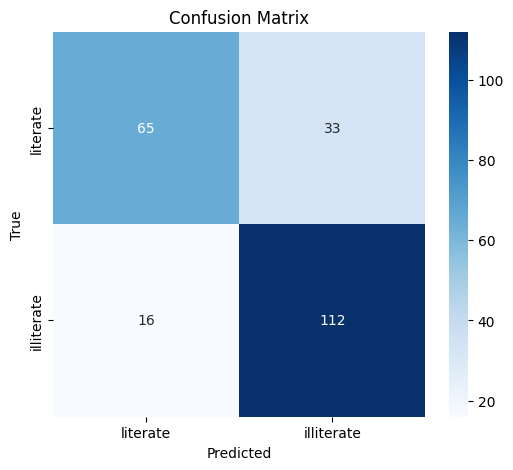

              precision    recall  f1-score   support

    literate       0.80      0.66      0.73        98
  illiterate       0.77      0.88      0.82       128

    accuracy                           0.78       226
   macro avg       0.79      0.77      0.77       226
weighted avg       0.79      0.78      0.78       226



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- Collect predictions and labels ---
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, sequences, seq_lengths, labels in test_loader:
        images, sequences, seq_lengths, labels = (
            images.to(device),
            sequences.to(device),
            seq_lengths.to(device),
            labels.to(device)
        )

        outputs = model(images, sequences, seq_lengths)
        preds = outputs.argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
classes = ["literate", "illiterate"]  # adjust if reversed

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# --- Classification Report ---
print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))


In [ ]:
batch_size = 4
seq_len = 30     # number of timesteps in your series
input_size = 2   # features per timestep

# generate dummy inputs
scan_path = torch.randn(batch_size, 1, 150, 150, device=device, dtype=torch.float32)
time_series = torch.randn(batch_size, seq_len, input_size, device=device, dtype=torch.float32)
seq_lengths = torch.tensor([seq_len] * batch_size, dtype=torch.long, device=device)  # all full-length sequences

# run forward pass (no hidden needed)
output = model(scan_path, time_series, seq_lengths)

print("Output shape:", output.shape)
print("Output logits:", output)

RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
print(model)

VTNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=18496, out_features=50, bias=True)
  (fc2): Linear(in_features=306, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
  (rnn): GRU(2, 256, batch_first=True)
)


Below was a function used to rename the scanpath files. It is no longer needed.

In [ ]:

import os

# Base folder
base_folder = "Scanpaths/contaminated"
subfolders = ["literate", "illiterate"]

for sub in subfolders:
    folder_path = os.path.join(base_folder, sub)
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".png") and "_scanpath" in filename:
            old_path = os.path.join(folder_path, filename)
            new_filename = filename.replace("_scanpath", "")
            new_path = os.path.join(folder_path, new_filename)
            os.rename(old_path, new_path)
            print(f"Renamed: {filename} -> {new_filename}")
